In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utilsCPD import *
import matplotlib.pyplot as plt

BATCH_SIZE  =32
mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True, transform=mnist_transforms)
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [356]:
all_batches = []
all_labels =[]
torch.manual_seed(10)
for x,y in test_dataloader:
    bs = x.shape[0]
    all_batches.append(x.flatten().reshape(bs,784))
    all_labels.append(y)

all_batches = torch.cat(all_batches,dim=0)
all_labels = torch.cat(all_labels,dim=0)



data_c1 = all_batches[all_labels==1].detach().numpy()
data_c2 = all_batches[all_labels==7].detach().numpy()
data_c3 = all_batches[all_labels==9].detach().numpy()


#DATA = np.vstack((data_c1[:100,:],data_c2[400:600,:],data_c1[100:700,:]))
DATA = np.vstack((data_c1[:300],data_c2[:200],data_c1[:200]))


In [31]:
d=1000
mu1 = np.zeros(d)
mu2 = mu1.copy()
mu2[0] = 20


seg1 = np.random.multivariate_normal(mu1,np.eye(d),100)
seg2 = np.random.multivariate_normal(mu2,np.eye(d),500)
seg3 = np.random.multivariate_normal(mu1,np.eye(d),500)


DATA = np.vstack((seg1,seg2,seg3),dtype=np.float32)


In [5]:
import pandas as pd

#pd.DataFrame(DATA).to_csv('DATA.csv')

np.save('MNIST_dummy.npy',DATA)

In [364]:
from tqdm import tqdm
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
LENGHT = 50
train_dataloader_ts = DataLoader(TimeseriesDataset(DATA,LENGHT,split=0.5))
SWDs = []

calibrated = False
t = 0
skip_count = 0  # To track the number of skipped iterations
segmentation ={}
segments=0
t0=int(LENGHT*0.5)-1
begin = time.time()
loss_segments = []
THETA = sample_theta_torch(DATA, 5000)
for i, d in enumerate(tqdm(train_dataloader_ts)):
    # Skip iterations if `skip_count` is active
    if skip_count > 0:
        skip_count -= 1
        continue

    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    #THETA = sample_theta_torch(x_ref, 5000)
    #print(THETA.dtype)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=4, device=device).sum(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    SWDs.append(loss.mean())

    # Calibration phase
    if not calibrated:
        alpha_hat, beta_hat = mom_estimates(loss)
        #print('Calibration at {}'.format(i+LENGHT))
        #print(f"Calibration: alpha={alpha_hat}, beta={beta_hat}")
        calibrated = True
        lower_CI = [0]
        upper_CI = [0]
        cumsum = loss.mean()
        t = 1 
        #last_cal = 0 

    # Monitoring phase
    if calibrated:
        #last_cal += 1 
        l, u = gamma_conf_interval(t, alpha_hat, 1 / beta_hat, 0.99)
        lower_CI.append(l)
        upper_CI.append(u)
        cumsum += loss.mean()
        t += 1

        # Check if a change point is detected
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at iteration {i + int(LENGHT*0.5)}")
            #print(mom_estimates(loss))
            #print(mom_estimates(np.hstack(loss_segments)))
            
            segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
            calibrated = False  # Reset calibration
            cumsum = 0
            t = 0
            skip_count = int(LENGHT*0.5)  # Skip the next 15 iterations
            SWDs = []
            segments+=1
            t0=i+LENGHT
            
        
segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
end = time.time()
print(end-begin)

  0%|          | 0/651 [00:00<?, ?it/s]

 55%|█████▍    | 357/651 [00:00<00:00, 534.34it/s]

Change Alarm at iteration 293


 91%|█████████▏| 595/651 [00:01<00:00, 537.74it/s]

Change Alarm at iteration 505


100%|██████████| 651/651 [00:01<00:00, 505.79it/s]

1.3041138648986816


In [4]:
def plot_statistic(ax,data,ax2):
    c = 0
    for key in data:
        segment = data[key]
        if c == 0:
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0,label='SWD')
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5,label='Test statstic')
        else: 
            ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0)
            ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['lower'],color='blue',lw=1,alpha=0.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],color='blue',lw=1,alpha=0.5)
        ax.fill_between(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],segment['lower'],color='blue',alpha=0.2)
        c+=1

    return ax

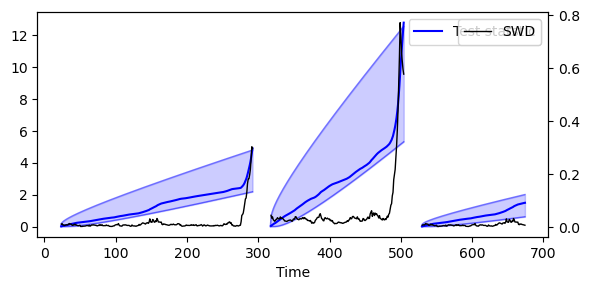

In [365]:
fig, ax = plt.subplots(figsize=(6,3))
ax2 = ax.twinx()
plot_statistic(ax,segmentation,ax2)
ax.legend()
ax2.legend()
ax.set_xlabel('Time')
fig.tight_layout()

In [20]:
import pandas as pd

  0%|          | 0/551 [00:00<?, ?it/s]

100%|██████████| 551/551 [00:01<00:00, 518.01it/s]


<Axes: >

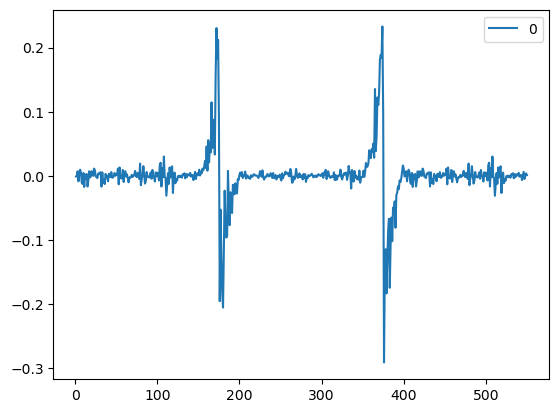

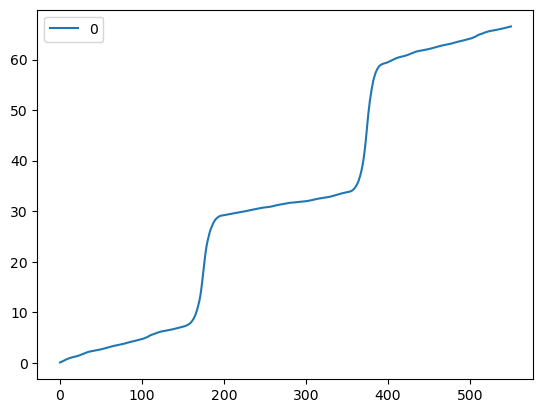

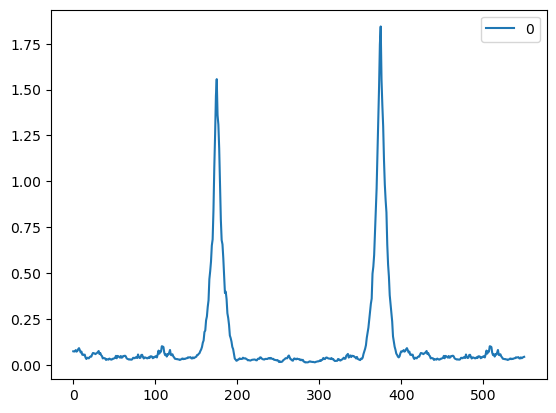

In [314]:
loss_segments = []
alphas= []
betas =[]
THETA = sample_theta_torch(DATA, 5000)
for i, d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=4, device=device).sum(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    a_hat, b_hat = mom_estimates(loss)
    alphas.append(a_hat)
    betas.append(b_hat)
    #SWDs.append(loss.mean())
df = pd.DataFrame([l.mean() for l in loss_segments])
df.diff().plot()
df.cumsum().plot()
df.plot()

In [342]:
CIA,CIB= estimate_parameter_CI(np.hstack(loss_segments[:5]),0.99)


In [246]:
pd.DataFrame(np.hstack([df.values,df.diff().values])).cov()

,0,1
0,0.869812,0.008939
1,0.008939,0.017761


In [248]:
1.09/0.7**2

2.224489795918368

In [188]:
2*df.iloc[400:,].std()

0    0.406868
dtype: float32

<Axes: >

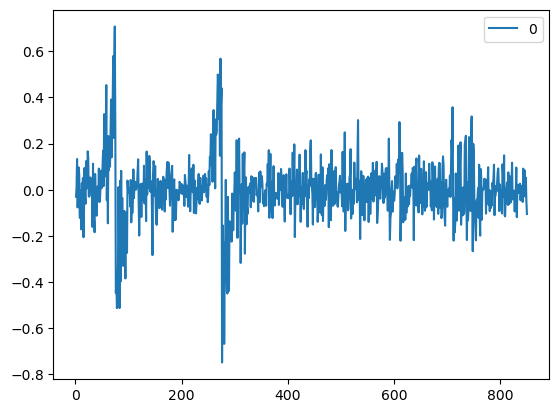

In [184]:
df.diff().plot()

In [142]:
2*1/(0.5)**2

8.0

22.22222222222222


0    20.538902
dtype: float64

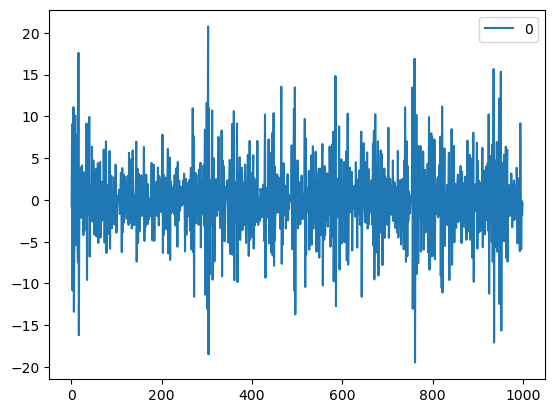

In [222]:
beta=0.3
RV = np.random.gamma(1,1/beta,1000)

print(2/(0.3)**2)
pd.DataFrame(RV).diff().plot()

pd.DataFrame(RV).diff().var()

In [62]:

df = pd.DataFrame([l.mean() for l in loss_segments])

In [36]:
alpha_hat

1.2759741010219752

In [50]:
df.std()

0    0.927461
dtype: float32

<Axes: >

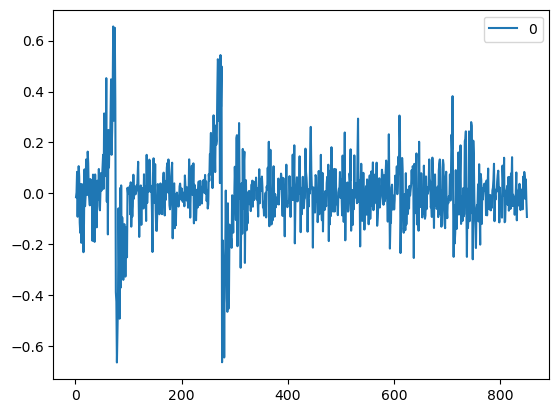

In [63]:
df.diff().plot()

 12%|█▏        | 20/171 [00:00<00:00, 191.34it/s]

1.335048022141591 75.97498


 47%|████▋     | 80/171 [00:00<00:00, 241.23it/s]

Change Alarm at 95


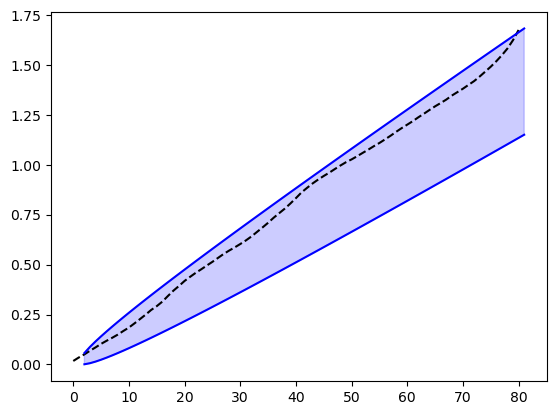

In [162]:
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader_ts = DataLoader(TimeseriesDataset(DATA,30,split=0.5))
SWDs = []

calibrated = False
t=0
for i , d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device),d[1].squeeze(0).to(device)
   
    THETA = sample_theta_torch(x_ref,1000)
    loss = project_and_calc_dist_torch(x_ref,x_cur,THETA,p=2,device=device).mean(axis=0).detach().cpu().numpy()

    
    
    SWDs.append(loss.mean())

    if not calibrated:
        alpha_hat,beta_hat = mom_estimates(loss)
        print(alpha_hat,beta_hat)
        calibrated = True
        lower_CI = [0]
        upper_CI  = [0]
        cumsum = loss.mean()
        t+=1

    if calibrated:
        l,u = gamma_conf_interval(i,alpha_hat,1/beta_hat,0.95)
        lower_CI.append(l)
        upper_CI.append(u)
        ###check change point
        cumsum+=loss.mean()
        if cumsum >= u or cumsum <= l:
            print("Change Alarm at {}".format(i+15))
            break
        


plt.plot(np.cumsum(SWDs),'--',color='black')
plt.plot(upper_CI,color='blue')

plt.plot(lower_CI,color='blue')
plt.fill_between(range(len(upper_CI)),upper_CI,lower_CI,color='blue',alpha=0.2);

  6%|▌         | 10/171 [00:00<00:00, 195.94it/s]

Warmup complete. Estimated parameters: alpha_hat=1.3129945745152551, beta_hat=76.23937225341797
Change Alarm at 25


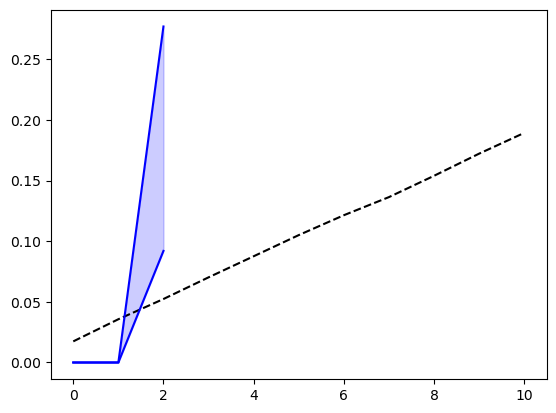

In [118]:
SWDs = []

calibrated = False
warmup = True
warmup_losses = []  # List to store losses during the warmup phase
warmup_steps = 10   # Number of steps for the warmup phase

for i, d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    THETA = sample_theta_torch(x_ref, 1000)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=2, device=device).mean(axis=0).detach().cpu().numpy()
    
    SWDs.append(loss.mean())

    if warmup and i < warmup_steps:
        # Collect losses during the warmup phase
        warmup_losses.append(loss)
        lower_CI = [0]
        upper_CI = [0]
        continue  # Skip the rest of the loop until warmup is complete
    
    if warmup and i == warmup_steps:
        # End of the warmup phase: Estimate parameters and start calibration
        warmup = False
        calibrated = True
        alpha_hat, beta_hat = mom_estimates(np.array(warmup_losses))  # Use collected warmup losses
        lower_CI.append(0)
        upper_CI.append(0)
        cumsum = np.mean(warmup_losses)  # Initialize cumulative sum with warmup mean
        print(f"Warmup complete. Estimated parameters: alpha_hat={alpha_hat}, beta_hat={beta_hat}")

    if calibrated:
        l, u = gamma_conf_interval(i , alpha_hat, 1 / beta_hat, 0.95)
        lower_CI.append(l)
        upper_CI.append(u)
        ### Check change point
        cumsum += loss.mean()
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at {i + 15}")
            break


plt.plot(np.cumsum(SWDs),'--',color='black')
plt.plot(upper_CI,color='blue')

plt.plot(lower_CI,color='blue')
plt.fill_between(range(len(upper_CI)),upper_CI,lower_CI,color='blue',alpha=0.2);